# Descriptive Statistics + Insights

 <u>Notes:</u>

Please run the utility file before the stat file to get the clean data frames

### Dependencies

In [295]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import numpy as np
from PIL import Image

### Getting the data

In [296]:
sales_df_stat = pd.read_pickle('sales.pkl')
sales_df_stat['date'] = pd.to_datetime(sales_df_stat['date'], format='%d-%m-%Y')

sales_df_stat.head()

,date,category,sales
0,2020-01-01,b,168.957105
1,2020-01-01,c,605.214724
2,2020-01-01,d,2534.086679
3,2020-01-01,e,699.861172
4,2020-01-01,f,206.322257


## Covariance Matrix:
Check correlations between products.

When looking at below heat map you can see a positive correlation all across the products, besided a negative value on the diagonal - 

which does not mean anything because its the same product relation (d <> d).

Products does not show a strong relation to each other so they can be grouped in the model.

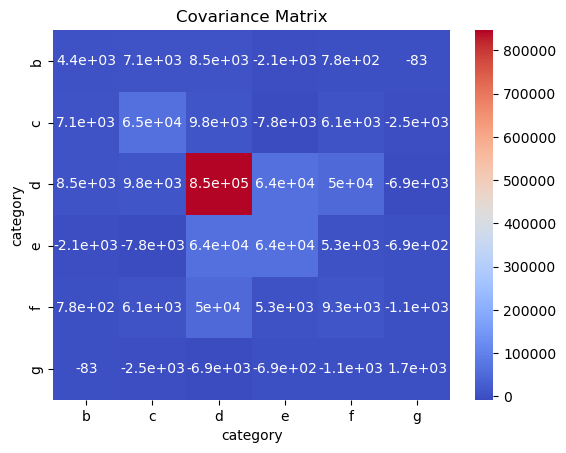

In [297]:
pivot_df = sales_df_stat.pivot(index='date', columns='category', values='sales')

cov_matrix = pivot_df.cov()

sns.heatmap(cov_matrix, annot=True, cmap='coolwarm')
plt.title('Covariance Matrix')
plt.show()

In [310]:
cov_matrix

category,b,c,d,e,f,g
category,,,,,,
b,4387.118765,7060.672991,8454.010191,-2094.031837,784.036295,-83.418634
c,7060.672991,65418.129899,9818.956623,-7803.049004,6136.013236,-2514.276691
d,8454.010191,9818.956623,846682.344726,64415.081819,49718.912627,-6878.266938
e,-2094.031837,-7803.049004,64415.081819,64381.919965,5337.852330,-687.051291
f,784.036295,6136.013236,49718.912627,5337.852330,9317.862855,-1080.946053
g,-83.418634,-2514.276691,-6878.266938,-687.051291,-1080.946053,1735.666732


## Quarterly Aggrigation:
Check for quarterly trends.

* Categories b, f, g show a quarter on quarter fixed trend - sales are identical all year long.
* Category e was pretty stable until Q2-2022 - then it started trending.
* Category d has quarterly trends worth noticing.
* Category c has such a mess in the data that cannot get any conclusions from it.


In [299]:
quarterly_sales = sales_df_stat.set_index('date', inplace = True)
quarterly_sales = sales_df_stat.groupby([pd.Grouper(freq='Q'), 'category'])['sales'].sum().unstack()
quarterly_sales.head()

category,b,c,d,e,f,g
date,,,,,,
2020-03-31,610.293032,1999.399810,9535.270764,2113.540427,901.088849,0.000000
2020-06-30,567.056955,1347.279405,4770.996787,1737.193675,561.927967,0.000000
2020-09-30,142.509373,924.347980,6870.272767,1919.840517,557.141267,0.000000
2020-12-31,528.672098,1687.347411,4147.883986,2010.880872,400.358338,0.000000
2021-03-31,698.929581,1859.725559,8526.461874,2267.371868,684.348439,5.682392


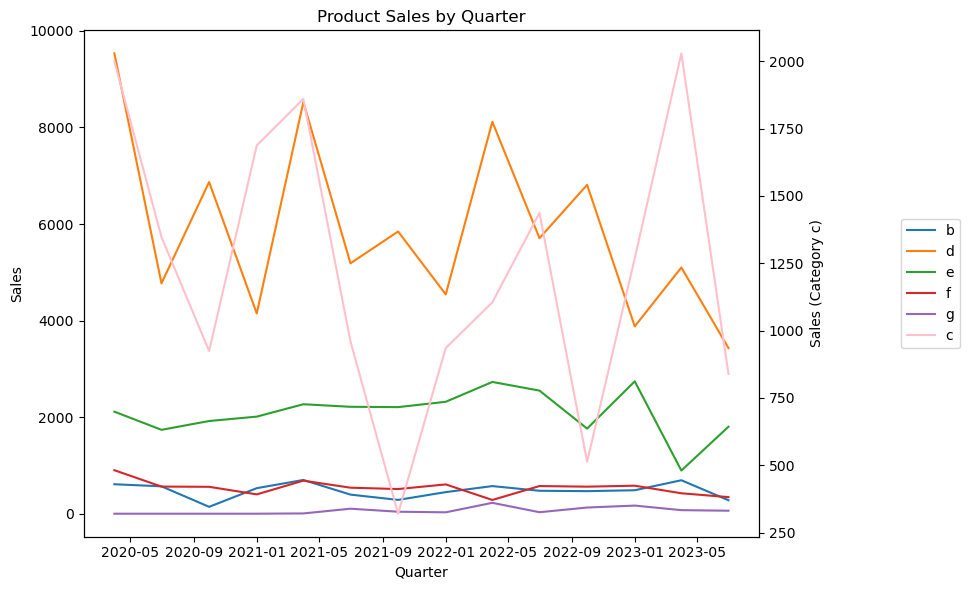

In [300]:
fig, ax1 = plt.subplots(figsize=(10, 6))

for category in quarterly_sales.columns:
    if category == 'c':
        continue
    ax1.plot(quarterly_sales.index, quarterly_sales[category], label=category)

ax1.set_xlabel('Quarter')
ax1.set_ylabel('Sales')
ax1.set_title('Product Sales by Quarter')

ax2 = ax1.twinx()
ax2.plot(quarterly_sales.index, quarterly_sales['c'], color='pink', label='c')
ax2.set_ylabel('Sales (Category c)')

handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles + handles2, labels + labels2, loc='center left', bbox_to_anchor=(1.2, 0.5))

plt.tight_layout()
plt.show()

<u>Note:</u>

Category 'C' had an anmonaly point around Sep-2022 - sales value was 1000 times grater then the average sales value - this can be assumed as an error and was removed in 

## Seasonal Decompose:
Check for seasonality trends.

* There is no clear trend in any of the categories.
* Category b + c + d has a seasonal factor but not a very clear one to get insights from 
* Comment for Category c - also the data for c is very messy so I would not interpret this in any way.
* Category e has a clear seasonality with drops every year in September (probably due to holidays).
* Category f would have no seasonality if not the drops in January every year - the rest of the year is pretty stable.

Seasonal Decomposition - Category b


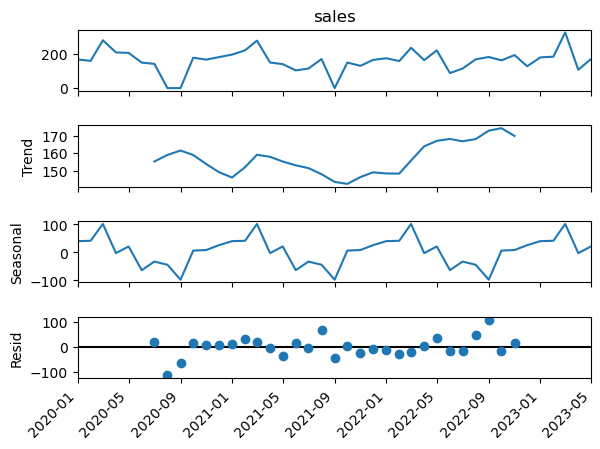



Seasonal Decomposition - Category c


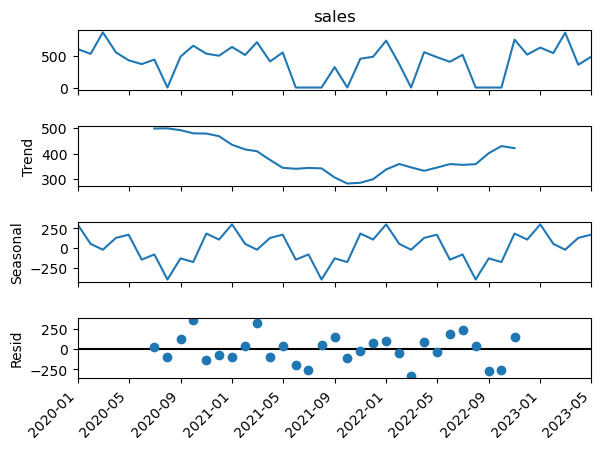



Seasonal Decomposition - Category d


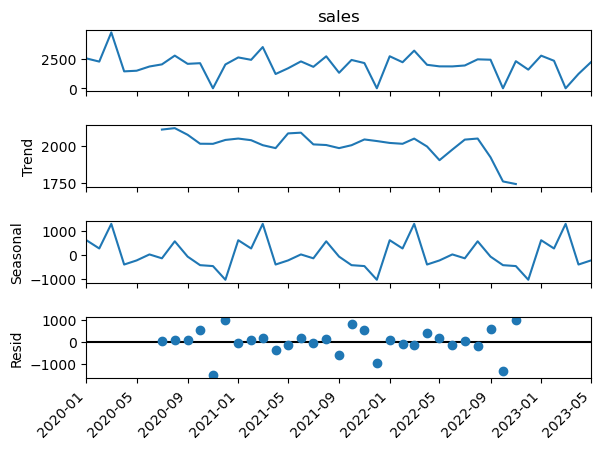



Seasonal Decomposition - Category e


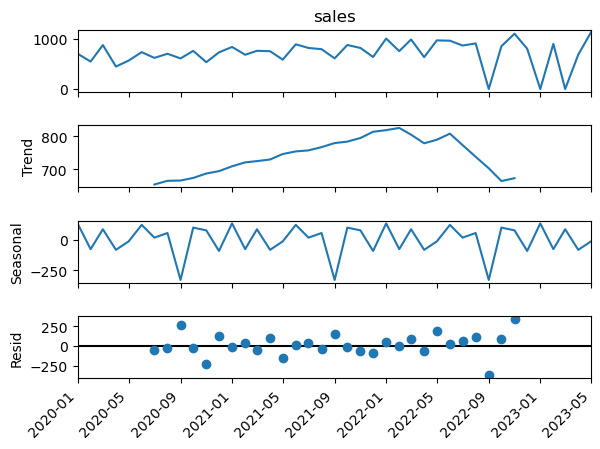



Seasonal Decomposition - Category f


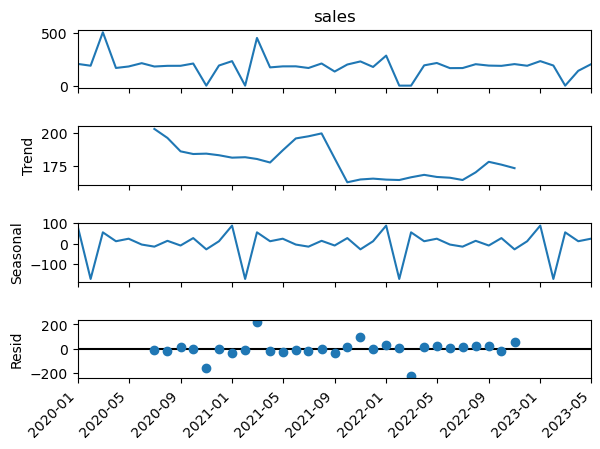



Seasonal Decomposition - Category g


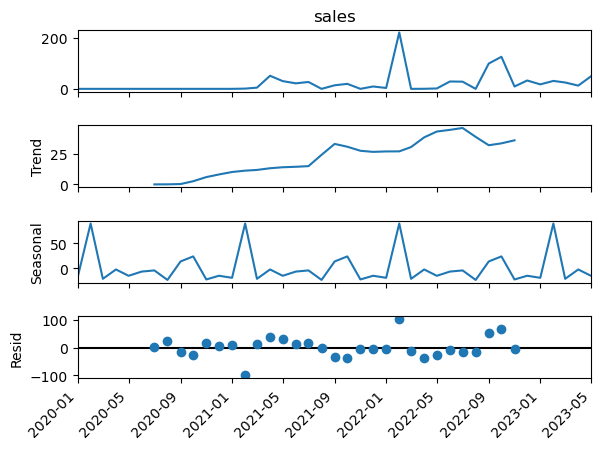

In [301]:
decomposition_df = sales_df_stat.sort_values('date')

for category in categories:
    category_data = decomposition_df[decomposition_df['category'] == category]
    
    decomposition = seasonal_decompose(category_data['sales'], model='additive', period=12)
    print(f'Seasonal Decomposition - Category {category}')
    
    fig = decomposition.plot()
    fig.autofmt_xdate(rotation=45)
    plt.savefig(f'seasonal_decomposition_{category}.jpg')
    plt.show()
    print('\n')

## Monthly Delta MA:
Want to check if two consecutive months can predict the upcoming 3rd month.
Is the 2 months average == value of the value of the 3td month then - if the values are osilating close to 1 - then we can use a short term MA model to predict.

**TL;DR - the monthly delta does not predict**

In [302]:
ma_df = sales_df_stat.reset_index()

In [303]:
categories = ma_df['category'].unique()
sales_delta = []

for category in categories:
    category_sales = ma_df[ma_df['category'] == category]['sales'].tolist()
    category_dates = ma_df[ma_df['category'] == category]['date'].tolist()

    for i in range(2, len(category_sales)):
        if category_sales[i] == 0:
            avg_sales_delta = 0
            sales_delta.append((category_dates[i], category, avg_sales_delta))
        else:
            avg_sales_delta = ((category_sales[i-2] + category_sales[i-1]) / 2) / category_sales[i]
            sales_delta.append((category_dates[i], category, avg_sales_delta))

sales_delta_df = pd.DataFrame(sales_delta, columns=['date', 'category', 'delta'])

sales_delta_df['date'] = pd.to_datetime(sales_delta_df['date'], format='%d-%m-%Y')
sales_delta_df = sales_delta_df.set_index('date').sort_values('date', ascending=True)

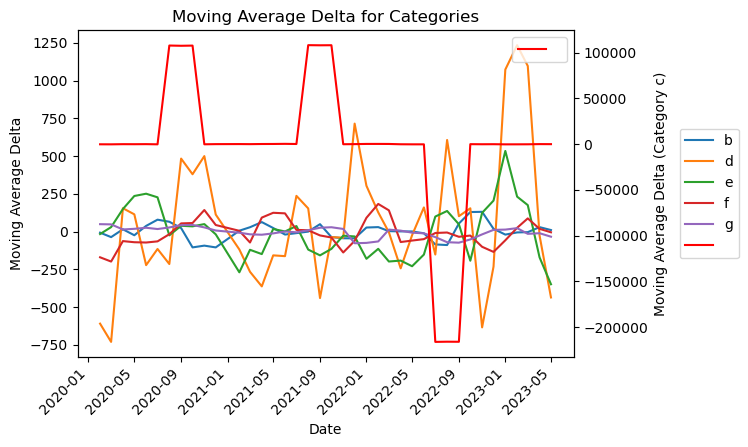

In [304]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

for category in categories:
    if category != 'c':
        ax1.plot(moving_avg[moving_avg['category'] == category]['date'], 
                 moving_avg[moving_avg['category'] == category]['delta'],
                 label=category)

ax2.plot(moving_avg[moving_avg['category'] == 'c']['date'], 
         moving_avg[moving_avg['category'] == 'c']['delta'], 
         color='red', label=' ')

ax1.set_xlabel('Date')
ax1.set_ylabel('Moving Average Delta')
ax2.set_ylabel('Moving Average Delta (Category c)')

handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles + handles2, labels + labels2, loc='center left', bbox_to_anchor=(1.2, 0.5))

plt.title('Moving Average Delta for Categories')
fig.autofmt_xdate(rotation=45)
plt.legend()
plt.show()

## Competitor Comparison
Our sales are higher 92.68% of the time!

In [305]:
monthly_sales = sales_df_stat.drop('category', axis = 1)
monthly_sales = monthly_sales.resample('M').sum().rename(columns = {'sales' : 'our_sales'}).reset_index()
monthly_sales['date'] = monthly_sales['date'].dt.to_period('M').dt.to_timestamp()

In [306]:
competitor_sales_df = pd.read_pickle('competitor_sales.pkl')
competitor_sales_df['date'] = competitor_sales_df['date'].dt.to_period('M').dt.to_timestamp()

In [307]:
merged_df = pd.merge(monthly_sales, competitor_sales_df, on='date', how='outer').rename(columns={'sales': 'competitor_sales'})

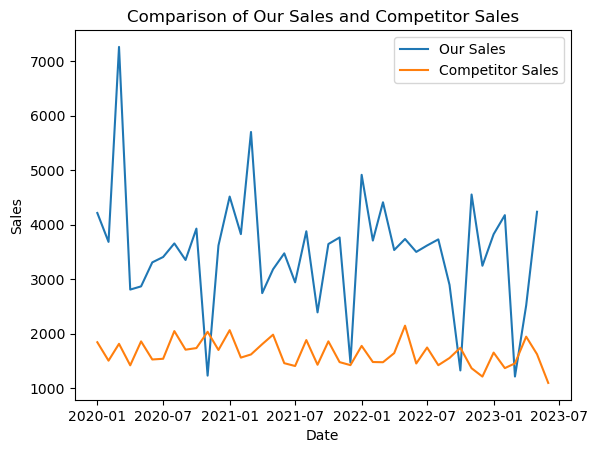

In [308]:
plt.plot(merged_df['date'], merged_df['our_sales'], label='Our Sales')
plt.plot(merged_df['date'], merged_df['competitor_sales'], label='Competitor Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Comparison of Our Sales and Competitor Sales')
plt.legend()
plt.show()

In [309]:
merged_df['delta'] = merged_df['our_sales'] - merged_df['competitor_sales']

# Calculate the percentage of positive delta values
positive_delta_percentage = (merged_df[merged_df['delta'] > 0]['delta'].count() / merged_df['delta'].count()) * 100
positive_delta_percentage

92.6829268292683